In [135]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.layers import Input, Dense, Lambda, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K
import numpy as np
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed

import seaborn as sns


import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt


# How to improve synthetic data generation
- e.g. interest rate often increase daily, and occassional fed intervention will keep overall interest rate in reasonble range, if we do not take fed intervention into account, the model will learn that interest rate often increases, and model's synthetic data show that interest rate increase to an unrealistically high level. **How to solve this issue?**

To incorporate the characteristic of occasional sharp decreases in interest rates due to federal intervention into your model, you could enhance your VAE model to account for non-linearities and regime changes. Here are a few strategies you could consider:

### 1. Conditional VAE (CVAE)
A Conditional Variational Autoencoder can incorporate conditional inputs that can influence the generated output. You can include a binary indicator or a categorical variable that represents periods of federal intervention (or the likelihood of such intervention). This approach would allow the model to learn different distributions for the interest rates under normal conditions and during interventions.

### Implementation Idea:
- **Conditional Input:** Add a new input layer to both the encoder and decoder that includes information about federal intervention. This could be a binary flag or a more nuanced feature that captures the intervention's intensity.
- **Modify the Model:** Adjust the encoder and decoder to accept this additional input. For example, concatenate this input with the latent vector before feeding it into the decoder.

### 2. External Regime Indicator
Incorporate an external regime indicator as part of the input data that signals when the federal intervention is likely or happening. This could be derived from market indicators, policy announcements, or historical intervention patterns. 

### Implementation Idea:
- **Regime Indicator:** Create a time series that indicates the regime (normal vs. intervention) based on historical data.
- **Model Input:** Include this regime indicator as an additional feature in the input data.

### 3. Hybrid Model with Reinforcement Learning
Consider a hybrid approach where you use reinforcement learning (RL) to model decision-making under uncertainty, such as the timing and effect of federal interventions. The RL agent could learn to predict interventions and their impacts on interest rates, which could then be fed into the VAE as conditional information.

### Implementation Idea:
- **RL Agent:** Develop an RL agent that learns policy actions (e.g., interventions) based on market conditions.
- **Integrate with VAE:** Use the output of the RL agent as an input to the VAE to adjust the predictions under potential intervention scenarios.

### 4. Custom Loss Function
Modify the loss function of the VAE to penalize unrealistic growth in interest rates. This could involve adding a term to the loss function that heavily penalizes predictions that lead to excessively high interest rates without corresponding indicators of federal intervention.

### Implementation Idea:
- **Penalty Term:** Add a penalty term to the VAE's loss function that activates when predicting high interest rates without a corresponding intervention indicator.

### 5. Post-processing Synthetic Data
Apply post-processing rules to the synthetic data generated by the VAE to adjust interest rates manually or algorithmically based on the characteristics of federal interventions. This could be a rule-based system that reduces interest rates in synthetic sequences that resemble conditions leading to interventions.

### Implementation Idea:
- **Rule-based Adjustments:** After generating synthetic data, apply a set of rules to adjust interest rates in scenarios that historically would lead to intervention.

Each of these approaches has its trade-offs in terms of model complexity, interpretability, and the need for additional data or assumptions. The choice of strategy would depend on the availability of data, computational resources, and the specific requirements of your modeling task.

In [77]:
raw = pd.read_excel('Macro_Data2.xlsx', index_col=0)
raw = raw.ffill().bfill()
raw

,DXY,S&P 500,Gold,USD Index Spot Rate,US 10YR Bonds
Date,,,,,
2023-02-03,102.919998,4136.48,1864.97,102.915,3.5246
2023-02-05,102.919998,4111.08,1867.48,103.621,3.6399
2023-02-06,103.620003,4164.00,1873.10,103.427,3.6735
2023-02-07,103.430000,4117.86,1875.49,103.409,3.6098
2023-02-08,103.410004,4081.50,1861.78,103.221,3.6579
...,...,...,...,...,...
2023-09-08,105.089996,4327.78,1932.82,106.648,4.6124
2023-09-10,105.089996,4373.63,1920.20,106.243,4.7060
2023-09-11,104.570000,4373.20,1923.18,106.250,4.8341


In [8]:
df2 = pd.DataFrame(index=raw.index)

for column in df.columns:
    # .expanding() --> to calculate the cumulative mean and variance
    df2[column + '_mean'] = df[column].pct_change().expanding().mean()
    df2[column + '_var'] = df[column].pct_change().expanding().var()
    
df2 = df2.dropna()

In [14]:
df = df2

In [44]:
# Normalize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df)

# Split the data (in this case, we're not splitting since it's unsupervised learning, but you might for validation)
X_train, X_test = train_test_split(scaled_features, test_size=0.2, random_state=42)

time_steps = 10  # This is an arbitrary choice for illustration

# Function to create a 3D array from 2D array of time series data
def create_sequences(data, time_steps):
    sequences = []
    for i in range(len(data) - time_steps + 1):
        sequences.append(data[i:(i + time_steps)])
    return np.array(sequences)

# Create sequences for training and testing sets
X_train = create_sequences(X_train, time_steps) # x_train[0] is the i'th day, x_train[1] is the i'th day till (i+1)'th day, x_train[3] are the columns for these 10 days
X_test = create_sequences(X_test, time_steps)

In [45]:
df.shape

(183, 10)

In [46]:
183*0.8

146.4

In [47]:
X_train.shape

(137, 10, 10)

In [35]:
df

,DXY_mean,DXY_var,S&P 500_mean,S&P 500_var,Gold_mean,Gold_var,USD Index Spot Rate_mean,USD Index Spot Rate_var,US 10YR Bonds_mean,US 10YR Bonds_var
Date,,,,,,,,,,
2023-02-06,0.003401,0.000023,0.003366,0.000181,0.002178,1.383677e-06,0.002494,0.000038,0.020972,0.000276
2023-02-07,0.001656,0.000021,-0.001450,0.000160,0.001877,9.628447e-07,0.001605,0.000021,0.008201,0.000627
2023-02-08,0.001194,0.000015,-0.003295,0.000120,-0.000420,2.174290e-05,0.000749,0.000017,0.009482,0.000425
2023-02-09,0.000587,0.000013,-0.002197,0.000096,0.000071,1.751297e-05,0.001392,0.000015,0.011637,0.000342
2023-02-10,0.001152,0.000012,0.000078,0.000108,-0.001020,2.115337e-05,0.000701,0.000015,0.008340,0.000339
...,...,...,...,...,...,...,...,...,...,...
2023-09-08,0.000123,0.000015,0.000282,0.000062,0.000231,6.628628e-05,0.000206,0.000016,0.001674,0.000357
2023-09-10,0.000122,0.000014,0.000339,0.000062,0.000194,6.617054e-05,0.000184,0.000016,0.001777,0.000357
2023-09-11,0.000095,0.000015,0.000337,0.000062,0.000201,6.581509e-05,0.000183,0.000016,0.001916,0.000359


In [133]:
df.describe()

,DXY_mean,DXY_var,S&P 500_mean,S&P 500_var,Gold_mean,Gold_var,USD Index Spot Rate_mean,USD Index Spot Rate_var,US 10YR Bonds_mean,US 10YR Bonds_var
count,183.000000,183.000000,183.000000,183.000000,183.000000,1.830000e+02,183.000000,183.000000,183.000000,183.000000
mean,0.000132,0.000016,-0.000002,0.000079,0.000464,7.475989e-05,0.000148,0.000018,0.001821,0.000443
std,0.000436,0.000003,0.000958,0.000017,0.000801,2.651261e-05,0.000417,0.000003,0.002786,0.000108
min,-0.000319,0.000009,-0.003295,0.000062,-0.001946,9.628447e-07,-0.000370,0.000010,-0.001162,0.000222
25%,-0.000097,0.000015,-0.000073,0.000064,0.000197,6.212367e-05,-0.000084,0.000017,0.000689,0.000366
50%,0.000013,0.000016,0.000281,0.000076,0.000350,7.444800e-05,0.000049,0.000018,0.001167,0.000427
75%,0.000115,0.000018,0.000594,0.000087,0.001029,9.396418e-05,0.000176,0.000020,0.001630,0.000526
max,0.003401,0.000023,0.003366,0.000181,0.002206,1.219708e-04,0.002494,0.000038,0.020972,0.000704


In [146]:
# Initialize dictionaries to store counts
positive_counts = {}
negative_counts = {}

# Loop through each column in the DataFrame
for column in ['DXY_mean', 'S&P 500_mean', 'Gold_mean', 'USD Index Spot Rate_mean', 'US 10YR Bonds_mean']:
    # Count positive values
    positive_count = (df[column] > 0).sum()
    positive_counts[column] = positive_count

    # Count negative values
    negative_count = (df[column] < 0).sum()
    negative_counts[column] = negative_count

In [147]:
positive_counts

{'DXY_mean': 100,
 'S&P 500_mean': 131,
 'Gold_mean': 157,
 'USD Index Spot Rate_mean': 111,
 'US 10YR Bonds_mean': 158}

In [148]:
negative_counts

{'DXY_mean': 83,
 'S&P 500_mean': 52,
 'Gold_mean': 26,
 'USD Index Spot Rate_mean': 72,
 'US 10YR Bonds_mean': 25}

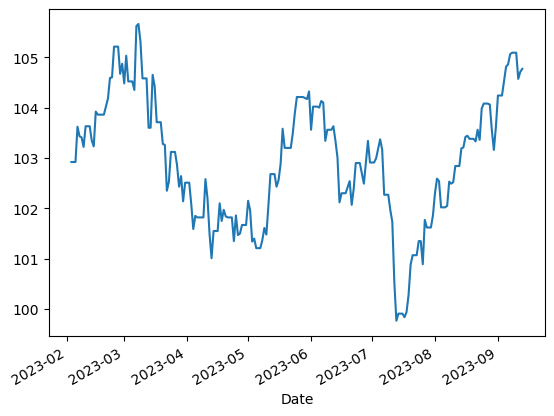

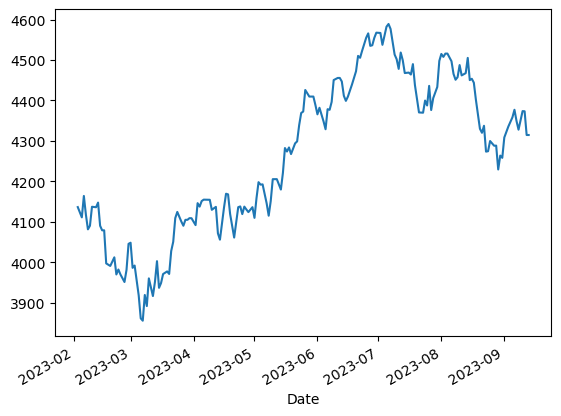

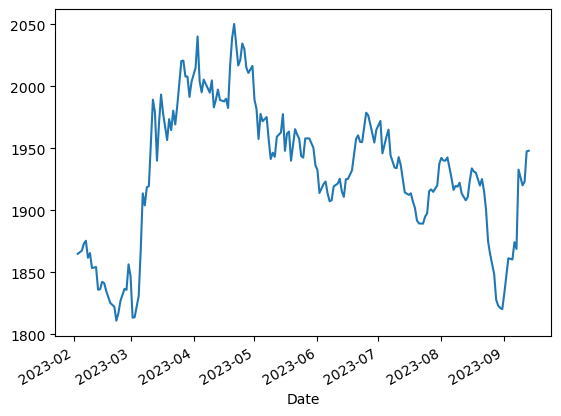

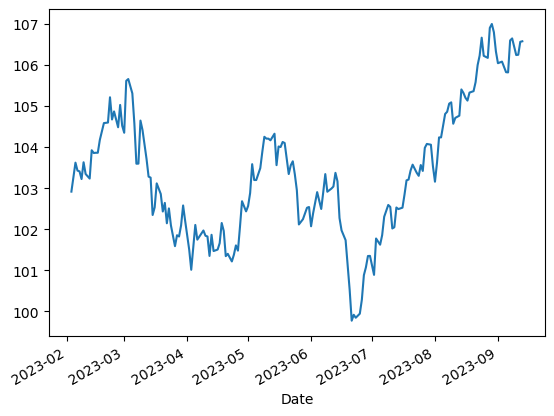

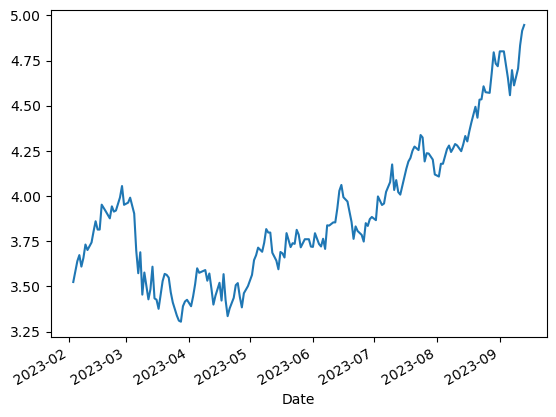

In [150]:
for each in raw.columns:
    raw[each].plot()
    plt.show()

In summary, your VAE model takes into account the entire multi-variate time series data as a whole, and through the encoder and decoder with LSTM layers, it learns to capture and generate sequences that preserve the temporal patterns and dependencies present in the input data. This makes it suitable for tasks involving the generation of synthetic time series data with complex temporal characteristics.

In [170]:
original_dim = X_train.shape[2]
input_shape = (time_steps, original_dim)
intermediate_dim = 64
latent_dim = 2

# Encoder with LSTM
inputs = Input(shape=input_shape, name='encoder_input')
encoded = LSTM(intermediate_dim)(inputs) # adding LSTM encoder layer means each time the vae model will see a sample of times series of data and will learn any temporarl pattern 
z_mean = Dense(latent_dim, name='z_mean')(encoded)
z_log_var = Dense(latent_dim, name='z_log_var')(encoded)

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Lambda: This is a layer constructor in Keras that allows you to wrap an arbitrary function or operation and use it as a layer within a Keras model
# It takes z_mean and z_log_var as input arguments and generates samples from the latent space.
# output_shape=(latent_dim,): This specifies the shape of the output produced by the Lambda layer
# name='z': This sets the name of the layer to 'z'.
# [z_mean, z_log_var]: These are the input tensors to the Lambda layer, and they are passed as a list to the Lambda layer. 
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# Decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = RepeatVector(time_steps)(latent_inputs)  # Set the number of time steps to repeat

######### About VAE's loss function ############
# the loss function for the VAE consists of a reconstruction loss, which 
# measures how well the model reconstructs input data, and a KL divergence 
# loss, which encourages the latent space to follow a desired distribution.
# These two terms are combined to create the overall VAE loss, which is 
# used during training to optimize the model's parameters.

# Decoder with LSTM layers
decoder_h = LSTM(intermediate_dim, return_sequences=True)(x)  # Use LSTM and return sequences
outputs = TimeDistributed(Dense(original_dim))(decoder_h)  # Apply Dense to each time step

# Custom activation function to limit values within a specific range
def custom_activation(x):
    return K.tanh(x)  # You can adjust the range by scaling and shifting if needed

# Decoder with LSTM layers and custom activation
decoder_h = LSTM(intermediate_dim, return_sequences=True)(x)  # Use LSTM and return sequences
outputs = TimeDistributed(Dense(original_dim, activation=custom_activation))(decoder_h)

# Instantiate encoder and decoder models
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(latent_inputs, outputs, name='decoder')

# VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

# Loss function
reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs)) # measures how well the VAE can reconstruct the input data.
reconstruction_loss *= time_steps * original_dim  # adjusting the scale of the reconstruction loss to make it comparable in magnitude to the KL divergence loss, so that the 2 loss components contribute approximately equally to the overall VAE loss.

# KL Divergence Loss (kl_loss) measures how well the learned latent space distribution matches a predefined standard normal distribution (multivariate Gaussian distribution). It quantifies the discrepancy between the learned distribution and the desired distribution
# This encourages the latent space to follow a predefined distribution, typically a multivariate Gaussian distribution. 
#  Kullback-Leibler (KL) divergence term
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)  # computes the KL divergence term for each sample in the batch.
kl_loss = K.sum(kl_loss, axis=-1) # sums up the KL divergence term over all dimensions.
kl_loss *= -0.5 # negative 0.5 scaling factor is applied to make it consistent with the definition of KL divergence loss for Gaussian distributions.
vae_loss = K.mean(reconstruction_loss + kl_loss) # computes the final VAE loss by taking the mean of the sum of the reconstruction loss and the KL divergence loss. It balances the importance of these two components.
vae.add_loss(vae_loss) # This adds the vae_loss to the VAE model as an additional loss term to be optimized during training.

# without early stopping, the final model used is always the last epoch which may not be the model with the best validation loss
# early stopping chose the model/epoch with the best validation model when there is no improvement of validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

vae.compile(optimizer='adam')
#################################################

In [171]:
# turn on early_stopping
vae.fit(X_train, X_train, epochs=1000, batch_size=32, validation_data=(X_test, X_test), callbacks=[early_stopping])

Epoch 1/1000
5/5 [==============================] - 5s 243ms/step - loss: 99.6486 - val_loss: 88.2366
Epoch 2/1000
5/5 [==============================] - 0s 16ms/step - loss: 103.9646 - val_loss: 88.1086
Epoch 3/1000
5/5 [==============================] - 0s 16ms/step - loss: 101.2701 - val_loss: 87.7480
Epoch 4/1000
5/5 [==============================] - 0s 14ms/step - loss: 97.2765 - val_loss: 87.8905
Epoch 5/1000
5/5 [==============================] - 0s 15ms/step - loss: 100.4978 - val_loss: 87.3785
Epoch 6/1000
5/5 [==============================] - 0s 15ms/step - loss: 96.1259 - val_loss: 87.2423
Epoch 7/1000
5/5 [==============================] - 0s 17ms/step - loss: 98.6958 - val_loss: 88.0084
Epoch 8/1000
5/5 [==============================] - 0s 15ms/step - loss: 101.9887 - val_loss: 87.7143
Epoch 9/1000
5/5 [==============================] - 0s 16ms/step - loss: 104.1801 - val_loss: 87.2726
Epoch 10/1000
5/5 [==============================] - 0s 16ms/step - loss: 95.3167 - v

In [172]:
# generates synthetic data points using the trained 'decoder' layer
# of the 'vae' VAE model

# when time step =10, we are using 10 days data to predict the 11th day

def generate_next_day_prediction(n_samples, seed):
    np.random.seed(seed)
    # Sample from the latent space
    z_sample = np.random.normal(size=(n_samples, latent_dim))
    # Generate synthetic data
    synthetic_sequences = decoder.predict(z_sample)
    # Take the last time step from each sequence as the next day's prediction
    next_day_predictions = synthetic_sequences[:, -1, :] # shape(each day, )
    # Inverse transform to return to original data space
    next_day_predictions = scaler.inverse_transform(next_day_predictions)
    return next_day_predictions

In [180]:
# Generate predictions for the next day
n_samples = 365  # Number of prediction sequences you want to generate
next_day_predictions = generate_next_day_prediction(n_samples, 0)

12/12 [==============================] - 0s 2ms/step


In [181]:
next_day_predictions_df = pd.DataFrame(next_day_predictions, columns=df.columns)

In [182]:
# data = next_day_predictions_df

# data_scaled = (data - data.min()) / (data.max() - data.min())

# plt.figure(figsize=(12, 6))

# colors = ['blue', 'green', 'red', 'yellow', 'purple']
# for col, color in zip(data_scaled.columns, colors):
#     plt.plot(data_scaled.iloc[:100,].index, data_scaled.iloc[:100,][col], label=col, color=color)

# plt.xlabel('Index')
# plt.ylabel('Normalized Values')
# plt.legend()
# plt.show()

In [183]:
n_steps = len(next_day_predictions_df)
stochastics_df = pd.DataFrame({},index=range(n_steps), columns=raw.columns)

for name in variables: 
    stochastics_df.iloc[0].loc[name] = raw.iloc[0].loc[name]

    for i in range(1, n_steps):
        mean =  next_day_predictions_df.iloc[i].loc[f'{name}_mean']
        var = next_day_predictions_df.iloc[i].loc[f'{name}_var']
        stochastics_df.iloc[i].loc[name] = stochastics_df.iloc[i-1].loc[name] * (1+ np.random.normal(mean, np.sqrt(var)))

In [184]:
stochastics_df.columns

Index(['DXY', 'S&P 500', 'Gold', 'USD Index Spot Rate', 'US 10YR Bonds'], dtype='object')

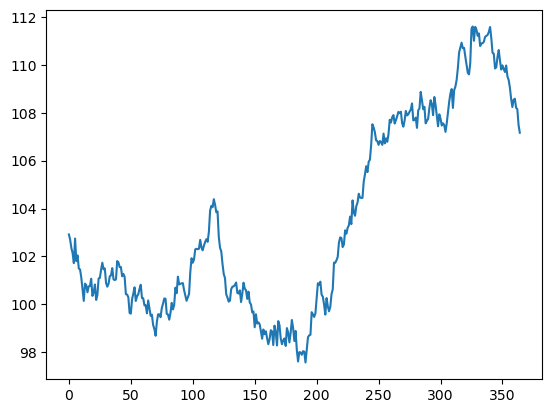

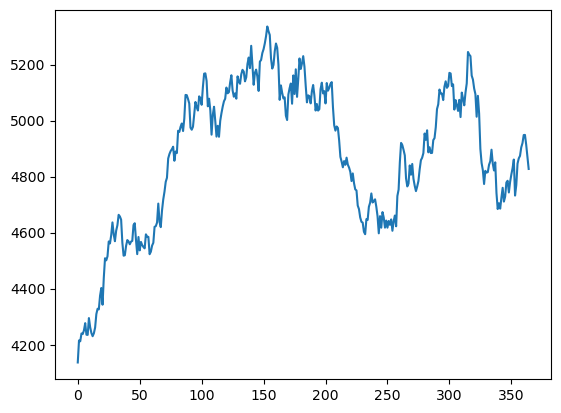

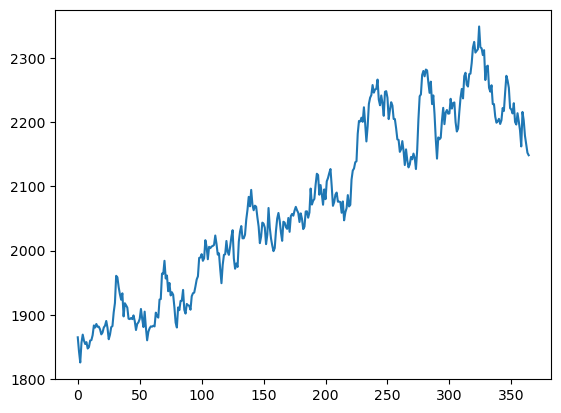

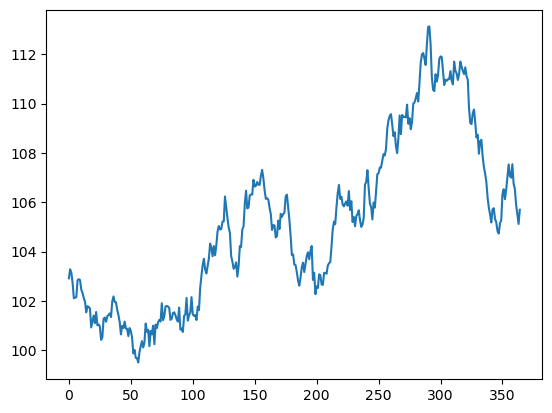

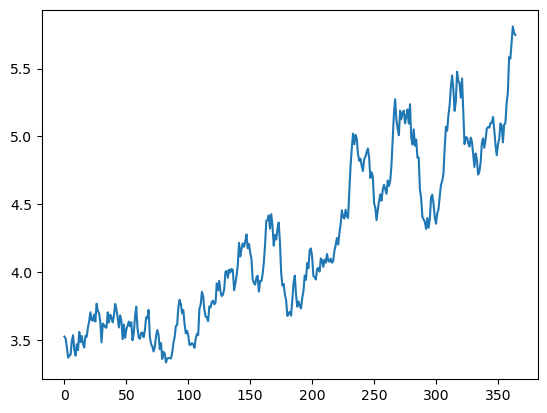

In [185]:
for name in variables: 
    stochastics_df[name].plot()
    plt.show()

In [186]:
stochastics_df

,DXY,S&P 500,Gold,USD Index Spot Rate,US 10YR Bonds
0,102.919998,4136.48,1864.97,102.915,3.5246
1,102.706943,4215.107086,1842.863917,103.283551,3.509531
2,102.351177,4212.169844,1825.806699,103.142272,3.443506
3,102.138188,4240.096538,1856.515903,102.727745,3.369117
4,101.7232,4237.923312,1869.157712,102.107644,3.38587
...,...,...,...,...,...
360,108.58262,4948.575199,2202.494557,106.546048,5.573254
361,108.207343,4949.053413,2178.622603,105.902315,5.689206
362,108.14721,4913.856686,2165.173948,105.532194,5.811153
363,107.486175,4869.831043,2152.090925,105.120313,5.764221
